In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

import statsmodels.api as sm
import pycaret.regression as pycr
import pycaret.utils as pycu
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objs as go
from plotly.subplots import make_subplots


In [2]:
# load final clean dataset
df = pd.read_csv('merged_clean_data.csv')
for_prediction = df.copy()

In [3]:
# convert date/time to date time format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
for_prediction['Date/Time'] = pd.to_datetime(df['Date/Time'])

# filter data to remove the rows that doesn't have productivity values
df = df[df['Date/Time'] <= '2021-12-31']

# set date/time as index
df.set_index('Date/Time', inplace = True)
for_prediction.set_index('Date/Time', inplace = True)


# drop unnecessary columns
sectors_todrop = ['Manufacturing', 'Utilities', 'Educational services', 'Accommodation and food services', 'Other services except public administration',
                  'Public administration', 'Finance and insurance, real estate and rental and leasing', 'Professional scientific and technical services',
                  'Information culture and recreation']

df.drop(columns = sectors_todrop, inplace = True)

# rename columns
df.rename(columns={'Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction': 'Agriculture'}, inplace=True)
for_prediction.rename(columns={'Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction': 'Agriculture'}, inplace=True)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85601 entries, 1998-01-01 to 2017-12-01
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   provincename                       85601 non-null  object 
 1   Longitude                          85601 non-null  float64
 2   Latitude                           85601 non-null  float64
 3   Region.Name                        85601 non-null  object 
 4   Construction                       85601 non-null  float64
 5   Transportation and warehousing     85601 non-null  float64
 6   Health care and social assistance  85601 non-null  float64
 7   Agriculture                        85601 non-null  float64
 8   Wholesale trade Retail trade       85601 non-null  float64
 9   Population                         85601 non-null  float64
 10  GeoUID                             85601 non-null  int64  
 11  Station Name                       85

In [5]:
# filter for ontario
df = df[df['provincename'] == 'British Columbia']

In [6]:
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

print(resampled.isnull().sum())

Longitude                            0
Latitude                             0
Construction                         0
Transportation and warehousing       0
Health care and social assistance    0
Agriculture                          0
Wholesale trade Retail trade         0
Population                           0
GeoUID                               0
Mean Max Temp (°C)                   0
Mean Min Temp (°C)                   0
Mean Temp (°C)                       0
Extr Max Temp (°C)                   0
Extr Min Temp (°C)                   0
Total Rain (mm)                      0
Total Snow (cm)                      0
Total Precip (mm)                    0
Snow Grnd Last Day (cm)              0
Dir of Max Gust (10s deg)            0
Spd of Max Gust (km/h)               0
dtype: int64


In [7]:
for_prediction = for_prediction[for_prediction['provincename'] == 'Ontario']
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = for_prediction.select_dtypes(include = ['number'])

# resample numeric data
resampled_for_prediction = num_cols.resample("M").mean()

print(resampled_for_prediction.isnull().sum())

Longitude                                                     0
Latitude                                                      0
Utilities                                                    25
Construction                                                 25
Manufacturing                                                25
Transportation and warehousing                               25
Educational services                                         25
Health care and social assistance                            25
Accommodation and food services                              25
Other services except public administration                  25
Public administration                                        25
Agriculture                                                  25
Wholesale trade Retail trade                                 25
Finance and insurance, real estate and rental and leasing    25
Professional scientific and technical services               25
Information culture and recreation      

<Axes: >

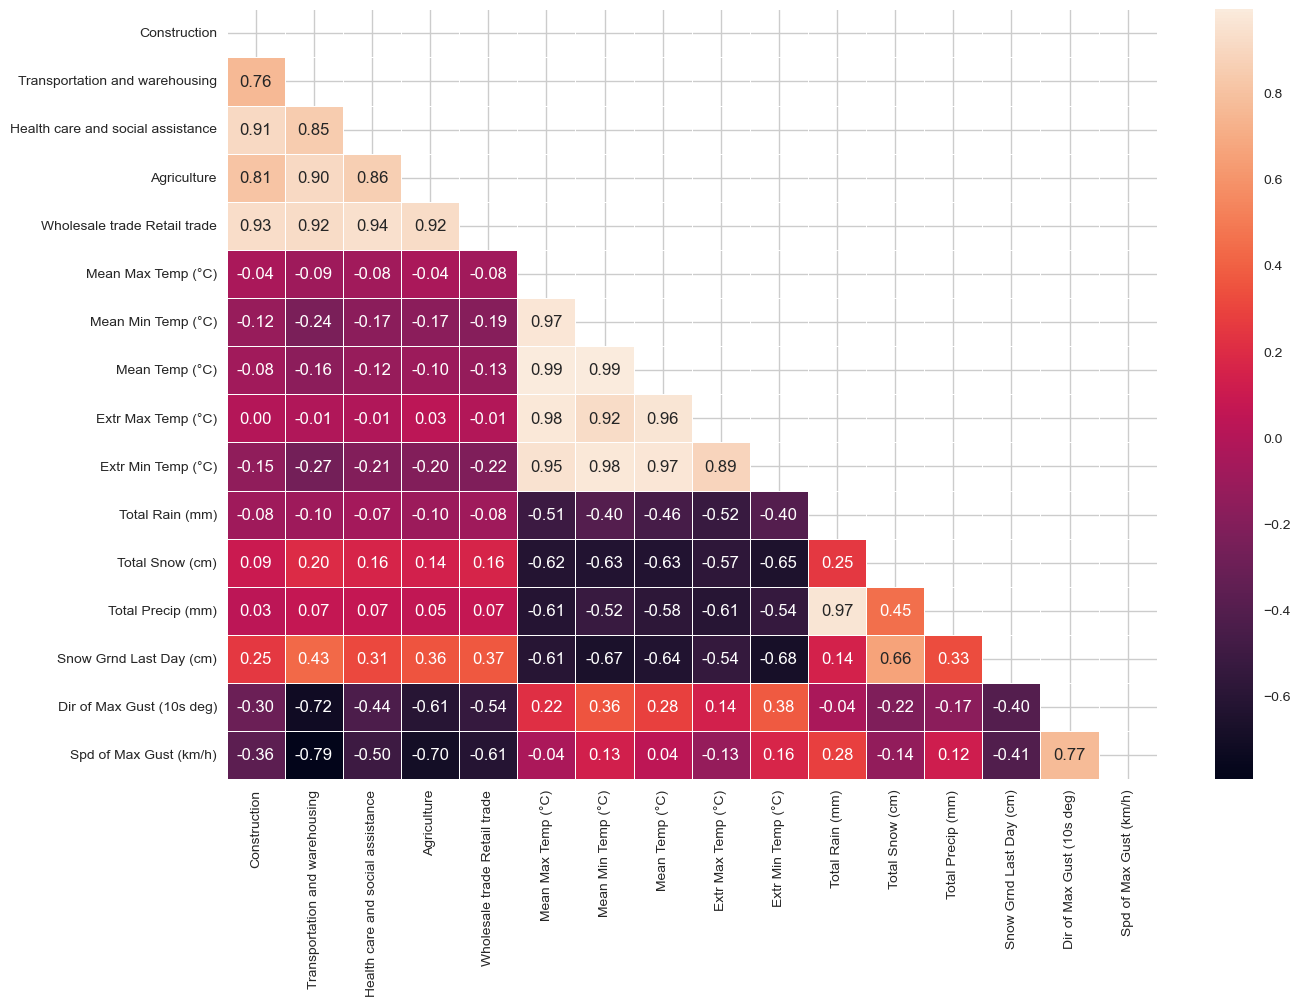

In [8]:
# CORRELATION MATRIX for combination of all 5 provinces #

# numeric columns
num_df = resampled.select_dtypes(include = ['number'])

# columns to exclude
to_drop = ['Longitude', 'Latitude', 'GeoUID', 'Population']

num_df.drop(columns = to_drop, inplace = True)

# correlation matrix
corr_matrix = num_df.corr()

# to remove the upper portion of the matrix; contains the same information
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# correlation matrix heatmap
plt.figure(figsize= (15, 10))
sns.heatmap(corr_matrix, mask = mask, annot = True, fmt = '.2f', linewidths= 0.5)

(1) Target Variable: Construction

In [9]:
# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Transportation and warehousing', 'Health care and social assistance',
                   'Agriculture', 'Wholesale trade Retail trade']
resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
test_data = resampled_con[resampled_con.index > train_end_date]

In [10]:
# set up the pycaret
pycaret_experiment = pycr.setup(data=train_data, target='Construction', session_id=1234,
                                preprocess = False)
# to check which model is the best to predict the target variable
best = pycr.compare_models(sort='R2')                    

,Description,Value
0,Session id,1234
1,Target,Construction
2,Target type,Regression
3,Original data shape,"(228, 12)"
4,Transformed data shape,"(228, 12)"
5,Transformed train set shape,"(159, 12)"
6,Transformed test set shape,"(69, 12)"
7,Numeric features,11


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,5.0356,44.0823,6.4863,0.2798,0.1264,0.1065,0.0420
en,Elastic Net,5.8204,53.7168,7.1538,0.1885,0.1393,0.1221,0.0140
llar,Lasso Least Angle Regression,5.8276,53.7853,7.1679,0.1862,0.1395,0.1223,0.0150
lasso,Lasso Regression,5.8279,53.7918,7.1685,0.1861,0.1395,0.1223,2.4400
ridge,Ridge Regression,5.8143,54.6027,7.1956,0.1797,0.1402,0.1217,0.0110
br,Bayesian Ridge,5.8060,54.0560,7.2101,0.1784,0.1403,0.1217,0.0130
rf,Random Forest Regressor,5.2426,48.1037,6.7838,0.1707,0.1322,0.1111,0.0650
lr,Linear Regression,5.8564,55.4270,7.2528,0.1650,0.1416,0.1227,2.2200
lightgbm,Light Gradient Boosting Machine,5.2115,45.5686,6.6459,0.1528,0.1316,0.1115,1.0100
omp,Orthogonal Matching Pursuit,5.9846,57.8291,7.4792,0.1497,0.1461,0.1254,0.0130


K Neighbors Regressor

In [11]:
# model creation using PyCaret
model = pycr.create_model('knn', fold = 5)

params = model.get_params()
print(params)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:09:47
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.8624,72.0597,8.4888,0.3854,0.1592,0.1395
1,5.2858,45.3789,6.7364,-0.0114,0.1384,0.1146
2,7.8711,98.6124,9.9304,0.1346,0.1899,0.1586
3,6.3670,64.1134,8.0071,0.3364,0.1508,0.1266
4,4.7802,32.5422,5.7046,-0.1293,0.1252,0.1149
Mean,6.2333,62.5413,7.7734,0.1431,0.1527,0.1308
Std,1.1050,22.7539,1.4543,0.1971,0.0219,0.0166


{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [12]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = train_data)

r2 = r2_score(predictions['Construction'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='K Neighbors Regressor: Actual vs Predicted Construction (Training Dataset)',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Construction',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,5.2602,45.3614,6.7351,0.4251,0.1311,0.1116


R-squared (R2) Score: 0.4250652594495282


In [13]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = test_data)
r2 = r2_score(predictions['Construction'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)


# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='K Neighbor Regressor: Actual vs Predicted Construction (Test Dataset)',
                  title_font_size=15, title_y=0.95,
                  xaxis_title='Date/Time', yaxis_title='Construction',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,47.3205,2696.5669,51.9285,-3.1797,0.6635,0.4486


R-squared (R2) Score: -3.1796795245036167


In [14]:
# tuning the pycaret model

model_tuned = pycr.tune_model(model)
params = model_tuned.get_params()
print(params)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:09:49
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.1359,79.8404,8.9353,0.3877,0.1664,0.1428
1,6.0489,53.8084,7.3354,0.4698,0.1392,0.1251
2,3.4480,19.1281,4.3736,0.4606,0.0901,0.0734
3,6.3615,61.3352,7.8317,-0.1429,0.1610,0.1393
4,6.5978,84.1003,9.1706,0.2078,0.1782,0.1353
5,8.8580,111.4938,10.5591,0.0829,0.1971,0.1742
6,6.6679,64.9798,8.0610,0.2646,0.1523,0.1313
7,5.6884,52.6111,7.2534,0.4598,0.1365,0.1188
8,4.7425,30.8368,5.5531,0.1669,0.1209,0.1114


Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}


In [15]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = train_data)
predictions.head()

r2 = r2_score(predictions['Construction'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='K Neighbor Regressor: Actual vs Predicted Construction (Training Dataset)',
                  title_font_size=15, title_y=0.95,  # Adjusted title_y value
                  xaxis_title='Date/Time', yaxis_title='Construction',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

R-squared (R2) Score: 0.8126823217110364


In [16]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = test_data)

r2 = r2_score(predictions['Construction'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='K Neighbors Regressor: Actual vs Predicted Construction (Test Dataset)',
                  title_font_size=15, title_y=0.95, 
                  xaxis_title='Date/Time', yaxis_title='Construction',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,47.7974,2761.6154,52.5511,-3.2805,0.6750,0.4526


R-squared (R2) Score: -3.2805044655148876


In [17]:
# SPLIT DATA to TRAIN, VALIDATION AND TEST DATA #

# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Transportation and warehousing', 'Health care and social assistance',
                   'Agriculture', 'Wholesale trade Retail trade']
resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
test_data = resampled_con[resampled_con.index > train_end_date]

# select feature and target variables
X_train = train_data[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y_train = train_data['Construction']

X_test = test_data[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y_test = test_data['Construction']

# further split into train and val
train_end_date = '2012-12-31'

# Filter the data based on the date range
X_val_data = X_train[X_train.index > train_end_date]
X_train_data = X_train[X_train.index < train_end_date]


y_val_data = y_train[y_train.index > train_end_date]
y_train_data = y_train[y_train.index < train_end_date]

In [18]:
# Initialize and train the KNeighborsRegressor model
model = KNeighborsRegressor(algorithm = 'auto',
                            leaf_size = 30,
                            metric = 'minkowski',
                            metric_params = None,
                            n_jobs = -1,
                            n_neighbors = 5,
                            p = 2,
                            weights = 'uniform')

model.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1)

In [19]:
# Make predictions on the train data
y_pred = model.predict(X_train_data)

# Calculate evaluation metrics
mse = mean_squared_error(y_train_data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_data, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Construction': y_train_data, 'prediction_label': y_pred}, index=X_train_data.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Construction (Training Dataset)',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Construction',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 47.2739865710101
Root Mean Squared Error (RMSE): 6.875608087362899
R-squared (R2): 0.5201972286650519


In [20]:
# Make predictions on the validation data
y_pred = model.predict(X_val_data)

# Calculate evaluation metrics
mse = mean_squared_error(y_val_data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_data, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Construction': y_val_data, 'prediction_label': y_pred}, index=X_val_data.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Construction (Validation Dataset)',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Construction',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 15.563435409085983
Root Mean Squared Error (RMSE): 3.945052016017784
R-squared (R2): -1.9682224074005434


In [21]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Construction': y_test, 'prediction_label': y_pred}, index=X_test.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Construction (Test Data)',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Construction',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 2729.373751547856
Root Mean Squared Error (RMSE): 52.243408689975965
R-squared (R2): -3.23052988840696


In [22]:
# select feature and target variables
X = resampled_for_prediction[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y = resampled_for_prediction['Construction']

# Make predictions on the whole data
y_pred = model.predict(X)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Construction': y, 'prediction_label': y_pred}, index=X.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Construction (Entire Dataset)',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Construction',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

(2) Target Variable: Transportation and warehousing

In [23]:
# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Construction', 'Health care and social assistance',
                   'Agriculture', 'Wholesale trade Retail trade']
resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
test_data = resampled_con[resampled_con.index > train_end_date]

In [24]:
# set up the pycaret
pycaret_experiment = pycr.setup(data=train_data, target='Transportation and warehousing', session_id=1234,
                                preprocess = False)
# to check which model is the best to predict the target variable
best = pycr.compare_models(sort='R2')                    

,Description,Value
0,Session id,1234
1,Target,Transportation and warehousing
2,Target type,Regression
3,Original data shape,"(228, 12)"
4,Transformed data shape,"(228, 12)"
5,Transformed train set shape,"(159, 12)"
6,Transformed test set shape,"(69, 12)"
7,Numeric features,11


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,2.6226,17.4855,3.7770,0.9462,0.1036,0.0821,0.0990
ada,AdaBoost Regressor,2.6103,18.7890,3.7897,0.9423,0.1008,0.0807,0.0220
rf,Random Forest Regressor,2.7774,19.1140,3.8988,0.9410,0.1056,0.0852,0.0510
et,Extra Trees Regressor,2.8276,19.7200,3.9483,0.9392,0.1063,0.0870,0.0390
knn,K Neighbors Regressor,2.9546,21.1026,4.0562,0.9348,0.1072,0.0887,0.0140
xgboost,Extreme Gradient Boosting,2.8809,21.1118,4.1915,0.9320,0.1140,0.0871,0.0810
gbr,Gradient Boosting Regressor,2.8743,22.2192,4.2244,0.9311,0.1094,0.0870,0.0270
dt,Decision Tree Regressor,3.6415,27.6732,4.9242,0.9124,0.1315,0.1095,0.0100
lar,Least Angle Regression,4.3147,33.1238,5.5681,0.8917,0.2019,0.1512,0.0090
ridge,Ridge Regression,4.2871,33.3929,5.5835,0.8914,0.1998,0.1488,0.0140


K Neighbors Regressor

In [25]:
# SPLIT DATA to TRAIN, VALIDATION AND TEST DATA #

# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Construction', 'Health care and social assistance',
                   'Agriculture', 'Wholesale trade Retail trade']
resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
test_data = resampled_con[resampled_con.index > train_end_date]

# select feature and target variables
X_train = train_data[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y_train = train_data['Transportation and warehousing']

X_test = test_data[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y_test = test_data['Transportation and warehousing']

# further split into train and val
train_end_date = '2012-12-31'

# Filter the data based on the date range
X_val_data = X_train[X_train.index > train_end_date]
X_train_data = X_train[X_train.index < train_end_date]


y_val_data = y_train[y_train.index > train_end_date]
y_train_data = y_train[y_train.index < train_end_date]

In [26]:
# Initialize and train the KNeighborsRegressor model
model = KNeighborsRegressor(algorithm='auto',
                            leaf_size=30,
                            metric='minkowski',
                            metric_params=None,
                            n_jobs=-1,
                            n_neighbors=5,
                            p=2,
                            weights='uniform')

model.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1)

In [27]:
# Make predictions on the train data
y_pred = model.predict(X_train_data)

# Calculate evaluation metrics
mse = mean_squared_error(y_train_data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_data, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Transportation and warehousing': y_train_data, 'prediction_label': y_pred}, index=X_train_data.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Transportation and warehousing'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Transportation and warehousing\n Training dataset',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Transportation and warehousing',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 15.840271925462037
Root Mean Squared Error (RMSE): 3.9799839102014016
R-squared (R2): 0.9497792219179498


In [28]:
# Make predictions on the validation data
y_pred = model.predict(X_val_data)

# Calculate evaluation metrics
mse = mean_squared_error(y_val_data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_data, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Transportation and warehousing': y_val_data, 'prediction_label': y_pred}, index=X_val_data.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Transportation and warehousing'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Transportation and warehousing\n Validation data',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Transportation and warehousing',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 3.466915957448966
Root Mean Squared Error (RMSE): 1.861965616612983
R-squared (R2): -1.076652190377093


In [29]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Transportation and warehousing': y_test, 'prediction_label': y_pred}, index=X_test.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Transportation and warehousing'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Transportation and warehousing\n Test Data',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Transportation and warehousing',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 356.9145025577056
Root Mean Squared Error (RMSE): 18.89218098996793
R-squared (R2): 0.17864027162923735


In [30]:
# select feature and target variables
X = resampled_for_prediction[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y = resampled_for_prediction['Transportation and warehousing']

# Make predictions on the test data
y_pred = model.predict(X)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Transportation and warehousing': y, 'prediction_label': y_pred}, index=X.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Transportation and warehousing'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Transportation and warehousing\n Whole Dataset',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Transportation and warehousing',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()


(3) Target Variable: Health care and social assistance

In [31]:
# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Construction', 'Transportation and warehousing',
                   'Agriculture', 'Wholesale trade Retail trade']
resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
# train_data = train_data[['Mean Max Temp (°C)', 'Construction']]
test_data = resampled_con[resampled_con.index > train_end_date]
# test_data = train_data[['Mean Max Temp (°C)', 'Construction']]


In [32]:
# set up the pycaret
pycaret_experiment = pycr.setup(data=train_data, target='Health care and social assistance', session_id=1234,
                                preprocess = False)
# to check which model is the best to predict the target variable
best = pycr.compare_models(sort='R2')                    

,Description,Value
0,Session id,1234
1,Target,Health care and social assistance
2,Target type,Regression
3,Original data shape,"(228, 12)"
4,Transformed data shape,"(228, 12)"
5,Transformed train set shape,"(159, 12)"
6,Transformed test set shape,"(69, 12)"
7,Numeric features,11


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,2.5119,10.0087,3.0830,0.4973,0.0531,0.0444,0.0290
lasso,Lasso Regression,2.4885,10.2003,3.1138,0.4952,0.0534,0.0439,0.0090
llar,Lasso Least Angle Regression,2.4885,10.2002,3.1137,0.4952,0.0534,0.0439,0.0100
br,Bayesian Ridge,2.4930,10.2592,3.1176,0.4904,0.0535,0.0440,0.0090
en,Elastic Net,2.4964,10.2833,3.1170,0.4879,0.0535,0.0440,0.0090
lightgbm,Light Gradient Boosting Machine,2.5728,10.6178,3.1700,0.4739,0.0547,0.0455,0.0810
ridge,Ridge Regression,2.4999,10.6377,3.1555,0.4717,0.0542,0.0441,0.0130
rf,Random Forest Regressor,2.4995,10.7530,3.1721,0.4671,0.0545,0.0441,0.0580
lr,Linear Regression,2.5314,10.8219,3.1818,0.4638,0.0547,0.0447,0.0090
et,Extra Trees Regressor,2.5820,10.9510,3.2309,0.4589,0.0558,0.0457,0.0340


K Neighbors Regressor

In [33]:
# SPLIT DATA to TRAIN, VALIDATION AND TEST DATA #

# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Construction', 'Transportation and warehousing',
                   'Agriculture', 'Wholesale trade Retail trade']
resampled_con = resampled.drop(columns=ignore_features)

# Filter the data based on the date range
train_end_date = '2016-12-31'
train_data = resampled_con[resampled_con.index <= train_end_date]
test_data = resampled_con[resampled_con.index > train_end_date]

# Select feature and target variables
X_train = train_data[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                      'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                      'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y_train = train_data['Health care and social assistance']  
X_test = test_data[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y_test = test_data['Health care and social assistance']  

# Further split into train and val
val_end_date = '2012-12-31'
X_val_data = X_train[X_train.index > val_end_date]
X_train_data = X_train[X_train.index <= val_end_date]

y_val_data = y_train[y_train.index > val_end_date]
y_train_data = y_train[y_train.index <= val_end_date]

In [34]:
# Initialize and train the KNeighborsRegressor model
model = KNeighborsRegressor(algorithm='auto',
                            leaf_size=30,
                            metric='minkowski',
                            metric_params=None,
                            n_jobs=-1,
                            n_neighbors=5,
                            p=2,
                            weights='uniform')

model.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1)

In [35]:
# Make predictions on the train data
y_pred = model.predict(X_train_data)

# Calculate evaluation metrics
mse = mean_squared_error(y_train_data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_data, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Health care and social assistance': y_train_data, 'prediction_label': y_pred}, index=X_train_data.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Health care and social assistance'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Health care and social assistance\n Training dataset',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Health care and social assistance',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 7.964180603243264
Root Mean Squared Error (RMSE): 2.8220879864460753
R-squared (R2): 0.6775894283354488


In [36]:
# Make predictions on the validation data
y_pred = model.predict(X_val_data)

# Calculate evaluation metrics
mse = mean_squared_error(y_val_data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_data, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Health care and social assistance': y_val_data, 'prediction_label': y_pred}, index=X_val_data.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Health care and social assistance'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Health care and social assistance\n Validation data',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Health care and social assistance',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 5.9779147645183
Root Mean Squared Error (RMSE): 2.4449774568527824
R-squared (R2): -0.4679973379198017


In [37]:
# select feature and target variables
X = resampled_for_prediction[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y = resampled_for_prediction['Health care and social assistance']

# Make predictions on the test data
y_pred = model.predict(X)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Health care and social assistance': y, 'prediction_label': y_pred}, index=X.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Health care and social assistance'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Health care and social assistance\n Whole Dataset',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Health care and social assistance',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()


(4) Target Variable: Agriculture

In [38]:
# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Construction', 'Transportation and warehousing',
                   'Health care and social assistance', 'Wholesale trade Retail trade']
resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
# train_data = train_data[['Mean Max Temp (°C)', 'Construction']]
test_data = resampled_con[resampled_con.index > train_end_date]
# test_data = train_data[['Mean Max Temp (°C)', 'Construction']]


In [39]:
# set up the pycaret
pycaret_experiment = pycr.setup(data=train_data, target='Agriculture', session_id=1234,
                                preprocess = False)
# to check which model is the best to predict the target variable
best = pycr.compare_models(sort='R2')                    

,Description,Value
0,Session id,1234
1,Target,Agriculture
2,Target type,Regression
3,Original data shape,"(228, 12)"
4,Transformed data shape,"(228, 12)"
5,Transformed train set shape,"(159, 12)"
6,Transformed test set shape,"(69, 12)"
7,Numeric features,11


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,4.5650,35.3055,5.8269,0.6587,0.1064,0.0878,0.0330
rf,Random Forest Regressor,4.6887,36.1524,5.9297,0.6422,0.1080,0.0900,0.0610
et,Extra Trees Regressor,4.7295,36.7936,5.9568,0.6356,0.1089,0.0905,0.0670
lasso,Lasso Regression,4.8912,37.3792,6.0321,0.6303,0.1108,0.0937,0.0130
llar,Lasso Least Angle Regression,4.8912,37.3786,6.0320,0.6303,0.1108,0.0937,0.0130
lightgbm,Light Gradient Boosting Machine,4.7475,37.6621,6.0694,0.6286,0.1109,0.0912,0.0880
br,Bayesian Ridge,4.9169,37.6451,6.0585,0.6276,0.1113,0.0943,0.0130
en,Elastic Net,4.8867,37.4817,6.0356,0.6270,0.1107,0.0936,0.0130
lr,Linear Regression,4.8687,38.4391,6.0919,0.6123,0.1117,0.0935,0.0130
ridge,Ridge Regression,4.9042,38.8645,6.1308,0.6100,0.1120,0.0939,0.0120


Lasso Least Angle Regression

In [40]:
# model creation using PyCaret
model = pycr.create_model('llar', fold = 5)

params = model.get_params()
print(params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.6634,36.7211,6.0598,0.7178,0.1016,0.0836
1,4.4109,27.6983,5.2629,0.6881,0.1002,0.0836
2,5.8941,53.6926,7.3275,0.5727,0.1318,0.1138
3,5.3689,42.3162,6.5051,0.5885,0.1234,0.1040
4,4.0878,26.4358,5.1416,0.6983,0.0974,0.0822
Mean,4.8850,37.3728,6.0594,0.6531,0.1109,0.0934
Std,0.6576,10.0440,0.8104,0.0602,0.0139,0.0130


{'alpha': 1.0, 'copy_X': True, 'eps': 2.220446049250313e-16, 'fit_intercept': True, 'fit_path': True, 'jitter': None, 'max_iter': 500, 'positive': False, 'precompute': 'auto', 'random_state': 1234, 'verbose': False}


In [41]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = train_data)

r2 = r2_score(predictions['Agriculture'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.5489,32.3097,5.6842,0.6919,0.1052,0.0883


R-squared (R2) Score: 0.691940668768582


In [42]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Agriculture'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Lasso Least Angle Regression: Actual vs Predicted Agriculture',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Agriculture',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [43]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = test_data)
r2 = r2_score(predictions['Agriculture'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

R-squared (R2) Score: -0.9226488643324307


In [44]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Agriculture'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Lasso Least Angle Regression: Actual vs Predicted Agriculture',
                  title_font_size=15, title_y=0.95,
                  xaxis_title='Date/Time', yaxis_title='Agriculture',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [45]:
model_tuned = pycr.tune_model(model)
params = model_tuned.get_params()
print(params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'alpha': 1.0, 'copy_X': True, 'eps': 2.220446049250313e-16, 'fit_intercept': True, 'fit_path': True, 'jitter': None, 'max_iter': 500, 'positive': False, 'precompute': 'auto', 'random_state': 1234, 'verbose': False}


In [46]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = train_data)
predictions.head()

r2 = r2_score(predictions['Agriculture'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.5489,32.3097,5.6842,0.6919,0.1052,0.0883


R-squared (R2) Score: 0.691940668768582


In [47]:
# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Agriculture'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Lasso Least Angle Regression: Actual vs Predicted Agriculture',
                  title_font_size=15, title_y=0.95,  # Adjusted title_y value
                  xaxis_title='Date/Time', yaxis_title='Agriculture',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [48]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = test_data)

r2 = r2_score(predictions['Agriculture'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,14.4448,268.2758,16.3791,-0.9226,0.2436,0.1947


R-squared (R2) Score: -0.9226488643324307


In [49]:
# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Agriculture'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Lasso Least Angle Regression: Actual vs Predicted Agriculture',
                  title_font_size=15, title_y=0.95,  # Adjusted title_y value
                  xaxis_title='Date/Time', yaxis_title='Agriculture',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [50]:
# SPLIT DATA to TRAIN, VALIDATION AND TEST DATA #

# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Construction', 'Transportation and warehousing',
                   'Health care and social assistance', 'Wholesale trade Retail trade']

resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
test_data = resampled_con[resampled_con.index > train_end_date]

# select feature and target variables
X_train = train_data[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y_train = train_data['Agriculture']

X_test = test_data[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y_test = test_data['Agriculture']

# further split into train and val
train_end_date = '2012-12-31'

# Filter the data based on the date range
X_val_data = X_train[X_train.index > train_end_date]
X_train_data = X_train[X_train.index < train_end_date]


y_val_data = y_train[y_train.index > train_end_date]
y_train_data = y_train[y_train.index < train_end_date]

In [51]:
from sklearn.linear_model import LassoLars

# Initialize and train the KNeighborsRegressor model
model = LassoLars(alpha = 1.0,
copy_X = True,
eps = 2.220446049250313e-16,
fit_intercept = True,
fit_path = True,
jitter = None,
max_iter = 500,
positive = False,
precompute = 'auto',
random_state = 1234,
verbose = False)

model.fit(X_train, y_train)

LassoLars(random_state=1234)

In [52]:
# Make predictions on the train data
y_pred = model.predict(X_train_data)

# Calculate evaluation metrics
mse = mean_squared_error(y_train_data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_data, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Agriculture': y_train_data, 'prediction_label': y_pred}, index=X_train_data.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Agriculture'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Agriculture\n Training dataset',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Agriculture',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 36.473251180224345
Root Mean Squared Error (RMSE): 6.039308832989446
R-squared (R2): 0.7029616875979696


In [53]:
# Make predictions on the validation data
y_pred = model.predict(X_val_data)

# Calculate evaluation metrics
mse = mean_squared_error(y_val_data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_data, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Agriculture': y_val_data, 'prediction_label': y_pred}, index=X_val_data.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Agriculture'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Agriculture\n Validation data',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Agriculture',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 17.769485085741533
Root Mean Squared Error (RMSE): 4.215386706547993
R-squared (R2): -0.8092980498928395


In [54]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Agriculture': y_test, 'prediction_label': y_pred}, index=X_test.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Agriculture'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Agriculture\n Test Data',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Agriculture',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 296.68348848544844
Root Mean Squared Error (RMSE): 17.224502561335363
R-squared (R2): -1.1262383560423803


In [55]:
# select feature and target variables
X = resampled_for_prediction[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y = resampled_for_prediction['Agriculture']


In [56]:
# Make predictions on the test data
y_pred = model.predict(X)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Agriculture': y, 'prediction_label': y_pred}, index=X.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Agriculture'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='KNeighbors Regressor: Actual vs Predicted Agriculture\n Whole Dataset',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Agriculture',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

(5) Target Variable: Wholesale trade Retail trade

In [57]:
# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Construction', 'Transportation and warehousing',
                   'Health care and social assistance', 'Agriculture']
resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
# train_data = train_data[['Mean Max Temp (°C)', 'Construction']]
test_data = resampled_con[resampled_con.index > train_end_date]
# test_data = train_data[['Mean Max Temp (°C)', 'Construction']]


In [58]:
# set up the pycaret
pycaret_experiment = pycr.setup(data=train_data, target='Wholesale trade Retail trade', session_id=1234,
                                preprocess = False)
# to check which model is the best to predict the target variable
best = pycr.compare_models(sort='R2')                    

,Description,Value
0,Session id,1234
1,Target,Wholesale trade Retail trade
2,Target type,Regression
3,Original data shape,"(228, 12)"
4,Transformed data shape,"(228, 12)"
5,Transformed train set shape,"(159, 12)"
6,Transformed test set shape,"(69, 12)"
7,Numeric features,11


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,4.0431,31.0136,5.3362,0.8084,0.0849,0.0694,0.0380
lightgbm,Light Gradient Boosting Machine,4.1864,32.8403,5.5455,0.7989,0.0883,0.0710,0.1610
gbr,Gradient Boosting Regressor,4.3139,36.3762,5.8231,0.7751,0.0917,0.0733,0.0270
rf,Random Forest Regressor,4.2351,36.4469,5.8408,0.7751,0.0906,0.0715,0.0550
ada,AdaBoost Regressor,4.2971,37.3557,5.8739,0.7708,0.0899,0.0721,0.0240
xgboost,Extreme Gradient Boosting,4.5403,40.1254,6.2390,0.7375,0.0960,0.0760,0.0580
llar,Lasso Least Angle Regression,4.9933,46.0492,6.4298,0.7276,0.1013,0.0834,0.0110
lasso,Lasso Regression,4.9936,46.0535,6.4303,0.7275,0.1013,0.0834,0.0100
br,Bayesian Ridge,4.9828,46.1645,6.4415,0.7269,0.1015,0.0832,0.0110
en,Elastic Net,4.9887,46.3603,6.4378,0.7255,0.1013,0.0833,0.0120


Bayesian Ridge

In [59]:
# model creation using PyCaret
model = pycr.create_model('br', fold = 5)

params = model.get_params()
print(params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7589,48.1695,6.9404,0.7587,0.0972,0.0711
1,4.5419,37.6919,6.1394,0.7433,0.0960,0.0757
2,7.3785,89.7633,9.4743,0.5256,0.1456,0.1234
3,5.8670,50.6178,7.1146,0.6934,0.1168,0.1000
4,2.8947,14.4250,3.7980,0.8703,0.0676,0.0543
Mean,5.0882,48.1335,6.6934,0.7183,0.1047,0.0849
Std,1.4880,24.4315,1.8255,0.1124,0.0258,0.0242


{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'lambda_init': None, 'max_iter': None, 'n_iter': 'deprecated', 'tol': 0.001, 'verbose': False}


In [60]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = train_data)

r2 = r2_score(predictions['Wholesale trade Retail trade'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.7313,40.0029,6.3248,0.7584,0.0982,0.0792


R-squared (R2) Score: 0.7584165358157156


In [61]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Wholesale trade Retail trade'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Lasso Least Angle Regression: Actual vs Predicted Wholesale trade Retail trade',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Wholesale trade Retail trade',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [62]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = test_data)
r2 = r2_score(predictions['Wholesale trade Retail trade'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

R-squared (R2) Score: -2.075284425718731


In [63]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Wholesale trade Retail trade'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Lasso Least Angle Regression: Actual vs Predicted Wholesale trade Retail trade',
                  title_font_size=15, title_y=0.95,
                  xaxis_title='Date/Time', yaxis_title='Wholesale trade Retail trade',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [64]:
model_tuned = pycr.tune_model(model)
params = model_tuned.get_params()
print(params)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:11:01
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Bayesian Ridge


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.7830,82.7013,9.0940,0.6698,0.1238,0.0971
1,2.7692,12.6383,3.5550,0.9052,0.0579,0.0466
2,4.3438,31.4087,5.6043,0.7834,0.0906,0.0725
3,4.6439,43.2423,6.5759,0.7038,0.0995,0.0772
4,7.1236,76.9541,8.7724,0.6045,0.1414,0.1237
5,7.3471,91.5667,9.5690,0.5015,0.1412,0.1183
6,5.4977,45.5704,6.7506,0.6867,0.1101,0.0882
7,5.6244,48.7911,6.9851,0.6907,0.1157,0.1011
8,2.5475,10.9320,3.3064,0.9064,0.0613,0.0462


Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'alpha_1': 0.1, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': True, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 0.15, 'lambda_2': 0.0005, 'lambda_init': None, 'max_iter': None, 'n_iter': 'deprecated', 'tol': 0.001, 'verbose': False}


In [65]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = train_data)
predictions.head()

r2 = r2_score(predictions['Wholesale trade Retail trade'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.7330,40.0335,6.3272,0.7582,0.0982,0.0792


R-squared (R2) Score: 0.7582319347573364


In [66]:
# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Wholesale trade Retail trade'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Lasso Least Angle Regression: Actual vs Predicted Wholesale trade Retail trade',
                  title_font_size=15, title_y=0.95,  # Adjusted title_y value
                  xaxis_title='Date/Time', yaxis_title='Wholesale trade Retail trade',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [67]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = test_data)

r2 = r2_score(predictions['Wholesale trade Retail trade'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

R-squared (R2) Score: -2.080420541647057


In [68]:
# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Wholesale trade Retail trade'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Lasso Least Angle Regression: Actual vs Predicted Wholesale trade Retail trade',
                  title_font_size=15, title_y=0.95,  # Adjusted title_y value
                  xaxis_title='Date/Time', yaxis_title='Wholesale trade Retail trade',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [69]:
# SPLIT DATA to TRAIN, VALIDATION AND TEST DATA #

# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Construction', 'Transportation and warehousing',
                   'Health care and social assistance', 'Agriculture']

resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
test_data = resampled_con[resampled_con.index > train_end_date]

# select feature and target variables
X_train = train_data[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y_train = train_data['Wholesale trade Retail trade']

X_test = test_data[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y_test = test_data['Wholesale trade Retail trade']

# further split into train and val
train_end_date = '2012-12-31'

# Filter the data based on the date range
X_val_data = X_train[X_train.index > train_end_date]
X_train_data = X_train[X_train.index < train_end_date]


y_val_data = y_train[y_train.index > train_end_date]
y_train_data = y_train[y_train.index < train_end_date]

In [70]:
from sklearn.linear_model import BayesianRidge

# Initialize and train the KNeighborsRegressor model
model = BayesianRidge(alpha_1 = 0.1,
alpha_2 = 0.15,
alpha_init = None,
compute_score = True,
copy_X = True,
fit_intercept = True,
lambda_1 = 0.3,
lambda_2 = 0.1,
lambda_init = None,
max_iter = None,
n_iter = 'deprecated',
tol = 0.001,
verbose = False)

model.fit(X_train, y_train)

BayesianRidge(alpha_1=0.1, alpha_2=0.15, compute_score=True, lambda_1=0.3,
              lambda_2=0.1)

In [71]:
# Make predictions on the train data
y_pred = model.predict(X_train_data)

# Calculate evaluation metrics
mse = mean_squared_error(y_train_data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_data, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Wholesale trade Retail trade': y_train_data, 'prediction_label': y_pred}, index=X_train_data.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Wholesale trade Retail trade'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Bayesian Ridge: Actual vs Predicted Wholesale trade Retail trade\n Training dataset',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Wholesale trade Retail trade',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 46.922648874264794
Root Mean Squared Error (RMSE): 6.850010866726037
R-squared (R2): 0.7525802944478518


In [72]:
# Make predictions on the validation data
y_pred = model.predict(X_val_data)

# Calculate evaluation metrics
mse = mean_squared_error(y_val_data, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_data, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Wholesale trade Retail trade': y_val_data, 'prediction_label': y_pred}, index=X_val_data.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('KNeighbors Regressor: Actual vs Predicted Wholesale trade Retail trade'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Bayesian Ridge: Actual vs Predicted Wholesale trade Retail trade\n Validation data',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Wholesale trade Retail trade',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 11.522020473996678
Root Mean Squared Error (RMSE): 3.3944101805758065
R-squared (R2): -2.705642456013682


In [73]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Wholesale trade Retail trade': y_test, 'prediction_label': y_pred}, index=X_test.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Bayesian Ridgr: Actual vs Predicted Agriculture'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Bayesian Ridge: Actual vs Predicted Wholesale trade Retail trade\n Validation data',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Wholesale trade Retail trade',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

Mean Squared Error (MSE): 1244.0302264440677
Root Mean Squared Error (RMSE): 35.27081267059306
R-squared (R2): -1.9786236426081838


In [74]:
# select feature and target variables
X = resampled_for_prediction[['Mean Max Temp (°C)', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Max Temp (°C)',
                    'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
                    'Snow Grnd Last Day (cm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']]
y = resampled_for_prediction['Wholesale trade Retail trade']


In [75]:
# Make predictions on the test data
y_pred = model.predict(X)

# Combine y_test and y_pred into a DataFrame for easier plotting
predictions = pd.DataFrame({'Wholesale trade Retail trade': y, 'prediction_label': y_pred}, index=X.index)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Bayesian Ridge: Actual vs Predicted Wholesale trade Retail trade'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Bayesian Ridge: Actual vs Predicted Wholesale trade Retail trade\n Whole Dataset',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Wholesale trade Retail trade',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()